In [ ]:
## unimportant, makes the notebook deterministic

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Initialize and set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Use device:{device}")

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

import numpy
import random
random.seed(0)

import numpy as np
np.random.seed(0)

# Uncertainty for Deep Neural Networks

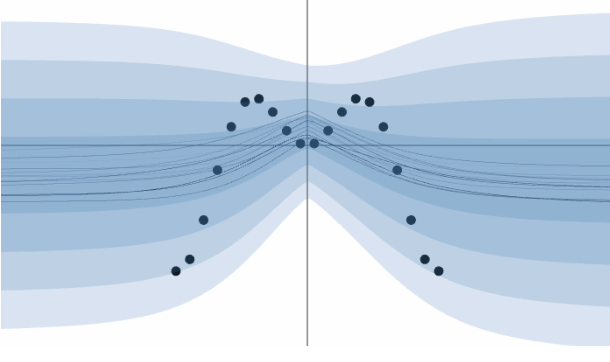

## Recap
Deep learning models are typically trained assuming that training and test data come from the same distribution (i.i.d. assumption). In reality, this assumption is often violated due to distribution shift, non-stationarity, and long-tailed distributions, leading to brittle models that break on out-of-distribution data. Overconfident predictions on data far from the training distribution pose significant risks in safety-critical applications like autonomous driving and medicine.

In this chapter, we will shortly summarize the most important points of the uncertainty lecture and than implement the two most popular methods (Monte Carlo dropout and deep ensembles).

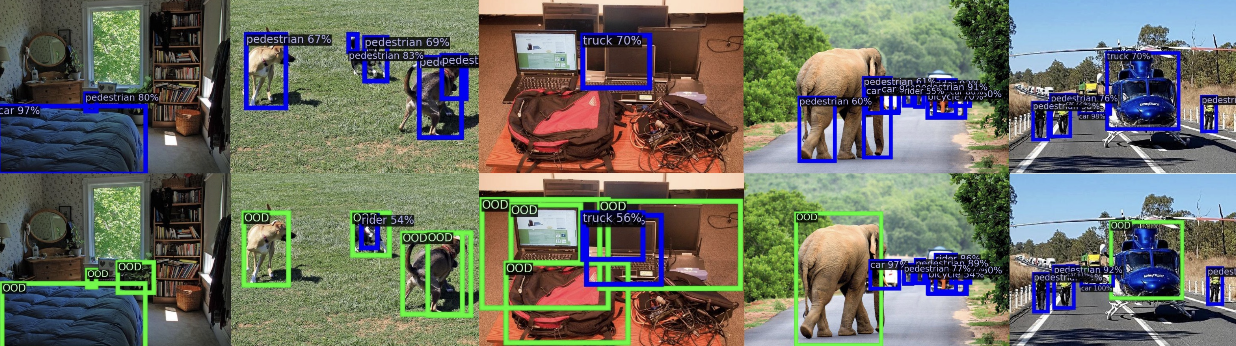

## Summary

### Uncertainty Types

Predictive uncertainty is made up of two different components:

1. **Aleatoric/Data uncertainty**: Uncertainty due to randomness in the input-output relationship of the data
   - Irreducible, given more data
2. **Epistemic/Model uncertainty**: Uncertainty due to a lack of knowledge about the optimal hypothesis/model/parameters
   - Reducible uncertainty: Can be reduced with more data

Aleatoric uncertainty can be further divided into:

1. Homoscedastic uncertainty: Uncertainty is constant and independent from input $x$
2. Heteroscedastic uncertainty: Uncertainty can vary and is dependent on input $x$



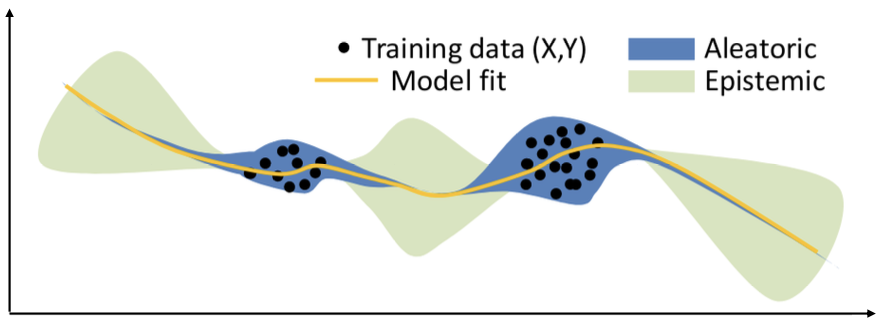

### Bayesian Probability Theory

Parameters $\theta$ are treated as random variables and each observed training example can incrementally decrease or increase the estimated probability that a set of them is correct

**Posterior**

$$p(\theta \mid X, Y, H)=\frac{p(Y \mid X, \theta, H) p(\theta \mid H)}{p(Y \mid X, H)}=\frac{p(Y \mid X, \theta, H) p(\theta \mid H)}{\int p(Y \mid X, \theta, H) p(\theta \mid H) d \theta}$$

- $H$: Hypothesis space, model architecture, class of functions - Usually omitted

- $p(\theta \mid X, Y, H)$ : Posterior of parameters $\theta$ after observing the dataset $(X, Y)$

- $p(Y \mid X, \theta, H)$ : Likelihood of dataset $(X, Y)$, given the parameters $\theta$

- $p(\theta \mid H)$ : Prior knowledge about the parameters $\theta$

- $p(Y \mid X, H)$ : Probability of observing the dataset $(X, Y)$

**Inference**

$$
p\left(y^{*} \mid x^{*}, X, Y\right)=\int p\left(y^{*} \mid x^{*}, \theta\right) p(\theta \mid X, Y) d \theta
$$

- $x^{*}, y^{*}:$ New data point

- $p\left(y^{*} \mid x^{*}, X, Y\right)$ : Predictive distribution (Bayesian model average)

- Average likelihood weighted by probability of each model $\theta$ (set of parameters)

- Can be used to calculate predictive uncertainty

**Problem**

Marginalization over parameters $\theta$ is usually intractable! Need good approximations.

- Monte Carlo Dropout
- Deep Ensembles
- ...

## Methods

### Regression Dataset

In this section, we will generate synthetic data to create a simple regression task. The goal is to fit a model that can learn the underlying sine function. We start by generating the training and testing data.

In [ ]:
x_train = torch.Tensor(np.linspace(-5, 5, 20))
x_test = torch.Tensor(np.linspace(-10, 10, 200))
y_train = torch.Tensor(np.sin(x_train))
y_test = torch.Tensor(np.sin(x_test))

traindataset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=20,
                                            shuffle=True,
                                            worker_init_fn=seed_worker,
                                            generator=g)

And now we will visualize the training data (dots) and the test data (solid line)

In [ ]:
plt.plot(x_test, y_test)
plt.scatter(x_train, y_train)

### Vanilla Regression Model

To start of, we will look at normal regression models without uncertainty to demonstrate how confidently wrong such models can be.

We first define a plain fully connected neural network.

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        width = 512
        self.fc1 = nn.Linear(1, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fc5 = nn.Linear(width, width)
        self.fc6 = nn.Linear(width, width)
        self.fc7 = nn.Linear(width, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

Now we will train the regression model for 100 epochs on the training data.

In [ ]:
regression_model = RegressionModel()
optimizer = torch.optim.AdamW(regression_model.parameters())
mse_loss = nn.L1Loss()
epochs = 100
regression_model.to(device)
for epoch in range(epochs):
    for batch, data in enumerate(trainloader):
        x, y = data
        x = x.to(device)
        x = torch.unsqueeze(x, -1)
        y = y.to(device)
        y = torch.unsqueeze(y, -1)
        optimizer.zero_grad()
        pred = regression_model(x)
        loss = mse_loss(pred, y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, batch: {batch}, train_loss: {loss.item()}")

Let's visualize how the model performs on datapoints we didn't observer during the training.

In [ ]:
x_test = x_test.to(device)
with torch.no_grad():
    pred = torch.squeeze(regression_model(torch.unsqueeze(x_test, -1)))

pred = pred.cpu()
x_test = x_test.cpu()

plt.scatter(x_train, y_train)

plt.plot(x_test, pred)

Now let's look on how the predictions should have looked like.

In [ ]:
x_test = x_test.to(device)
with torch.no_grad():
    pred = torch.squeeze(regression_model(torch.unsqueeze(x_test, -1)))

pred = pred.cpu()
x_test = x_test.cpu()

plt.plot(x_test, y_test)
plt.scatter(x_train, y_train)


plt.plot(x_test, pred)

Without some sort of uncertainty measure, our model can make huge mistakes without us noticing in the real world, where we don't have labeled data or supervision of the model.

We will now look at the two most common methods to estimate uncertainty for deep neural networks.

### Monte Carlo Dropout

**Idea**: Perform Dropout not only during training, but also during inference to approximate Bayesian inference

First we define a fully connected neural network with dropout applied after each dense layer.

In [ ]:
class DropoutModel(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        width = 512
        self.fc1 = nn.Linear(1, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fc5 = nn.Linear(width, width)
        self.fc6 = nn.Linear(width, width)
        self.fc7 = nn.Linear(width, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for each layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.fc7(x)
        # No dropout after the last layer
        return x

Now define how the model computes the predictive mean, and predictive variance. We apply dropout also during inference to obtain multiple samples with different model parameters. The function mc_prediction performs Monte Carlo dropout on a given input x using a provided mc_model. The number of samples are defined by mc_samples.

In [ ]:
def mc_prediction(x, mc_model, device, mc_samples=50):
    with torch.no_grad():
        x = x.to(device)
        x = torch.unsqueeze(x, -1)  # Need to add another dimension in order to process batch
        samples = [torch.squeeze(mc_model(x)) for _ in range(mc_samples)]
        samples = torch.stack(samples)  # Prediction for each model
        mean = torch.mean(samples, axis=0)  # Mean over all predictions
        variance = torch.var(samples, axis=0)  # Variance of predictions
    return samples.cpu(), mean.cpu(), variance.cpu()

Define training loop and train the model for 100 epochs.

In [ ]:
dropout_model = DropoutModel(dropout_rate=0.2)
optimizer = torch.optim.AdamW(dropout_model.parameters())
mse_loss = nn.L1Loss()
epochs = 100
dropout_model.to(device)
for epoch in range(epochs):
    for batch, data in enumerate(trainloader):
        x, y = data
        x = x.to(device)
        x = torch.unsqueeze(x, -1)
        y = y.to(device)
        y = torch.unsqueeze(y, -1)
        optimizer.zero_grad()
        pred = dropout_model(x)
        loss = mse_loss(pred, y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, batch: {batch}, train_loss: {loss.item()}")

Predict and visualize the test data

In [ ]:
samples, pred_mean, pred_variance = mc_prediction(x_test, dropout_model, device, mc_samples=100)

plt.plot(x_test, y_test)
plt.scatter(x_train, y_train)

#for sample in samples:
#  plt.plot(x_test, sample, alpha=0.5, linestyle="--")

plt.plot(x_test, pred_mean)

plt.fill_between(x_test, pred_mean-2*pred_variance**0.5, pred_mean+2*pred_variance**0.5, alpha=0.2)  # Plot confidence interval of 2 std. deviations

### Deep Ensembles

**Idea**: Learn an ensemble of models that approximate Bayesian inference

We first define the architecture of each ensemble member.

In [ ]:
class EnsembleMember(nn.Module):
    def __init__(self):
        super().__init__()
        width = 512
        self.fc1 = nn.Linear(1, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fc5 = nn.Linear(width, width)
        self.fc6 = nn.Linear(width, width)
        self.fc7 = nn.Linear(width, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

Now define how the model computes the predictive mean, and predictive variance. We perform inference on each model with the same input x and compute the mean and variance of all predictions.

In [ ]:
def ensemble_prediction(x, ensemble_model, device):
    with torch.no_grad():
        x = x.to(device)
        x = torch.unsqueeze(x, -1)
        samples = [torch.squeeze(ensemble_member(x)) for ensemble_member in ensemble_model]
        samples = torch.stack(samples)  # Prediction for each model
        mean = torch.mean(samples, axis=0)  # Mean over all predictions
        variance = torch.var(samples, axis=0)  # Variance of predictions
    return samples.cpu(), mean.cpu(), variance.cpu()

Define training loop and train the model for 100 epochs.

In [ ]:
epochs=100
ensemble_model = [EnsembleMember().to(device) for _ in range(5)]
for i, ensemble_member in enumerate(ensemble_model):
    optimizer = torch.optim.AdamW(ensemble_member.parameters())
    mse_loss = nn.L1Loss()

    print(f"Train member {i+1}")
    for epoch in range(epochs):
        for batch, data in enumerate(trainloader):
            x, y = data
            x = x.to(device)
            x = torch.unsqueeze(x, -1)
            y = y.to(device)
            y = torch.unsqueeze(y, -1)
            optimizer.zero_grad()
            pred = ensemble_member(x)
            loss = mse_loss(pred, y)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"epoch: {epoch}, batch: {batch}, train_loss: {loss.item()}")
print("finished")

Predict and visualize the test data

In [ ]:
samples, pred_mean, pred_variance = ensemble_prediction(x_test, ensemble_model, device)

plt.plot(x_test, y_test)
plt.scatter(x_train, y_train)

for sample in samples:
  plt.plot(x_test, sample, alpha=0.5, linestyle="--")

plt.plot(x_test, pred_mean)

plt.fill_between(x_test, pred_mean-2*pred_variance**0.5, pred_mean+2*pred_variance**0.5, alpha=0.2)  # Plot confidence interval of 2 std. deviations

# Active Learning

## Motivation
A key problem in deep learning is data efficiency. While excellent performance can be obtained with modern tools, these are often data-hungry, rendering the deployment of deep learning in the real-world challenging for many tasks.  In Active Learning we use a “human in the loop” approach to data labelling, reducing the amount of data that needs to be labelled drastically, and making machine learning applicable when labelling costs would be too high.





## Passive Learning
Tasks which involve gathering a large amount of data randomly sampled from the underlying distribution and using this large dataset to train a model that can perform some sort of prediction. This method has many disadvantages:
* Too many wasted samples.
* Learning is limited by sampling resolution

<img src=https://imgur.com/M7Afc39.png width="400">

## Definition and Concepts
Active Learning is a semi-supervised technique whose main hypothesis is that if a learning algorithm can select the data it wants to learn from, it can perform better than traditional methods with significantly less data for training. In other words, **Active Learning (AL) is an interactive approach to simultaneously build a labelled data set and train a machine learning model.**

**How to make machines curious to Learn?**


## Algorithm

1. A relatively large unlabeled dataset is gathered.
2. A domain expert labels a few positive examples in the dataset.

<img src=https://imgur.com/BHi6GRx.png width="400">

3. A classifier is trained on labeled samples.
4. The classifier is applied to the rest of the corpus.

<img src=https://imgur.com/ZPya6mX.png width="400">



5. Few most “useful” examples are selected (e.g., that increase classification performance).
6. The examples labeled by the expert are added to the training set.

<img src=https://imgur.com/yCSp1kU.png width="400">

7. Goto 3.


<img src=https://imgur.com/smisThj.png width="400">

<img src=https://imgur.com/NuD954f.png width="400">


Full Loop

<img src=https://modal-python.readthedocs.io/en/latest/_images/active-learning.png width="400">

## Measures of Uncertainty


### Low Confidence

The simplest measure of uncertainty is ***low confidence*** defined by slide 22. $$x_{LC}=\underset{x}{\operatorname{arg max}}1-P(\hat{y}|x)$$

Where x is the instance to be predicted and $\hat{y}$ is the certainty of the most likely prediction.

For example, if you have three classes [car, tree, plane] and your network's classification probabilities are [0.1 | 0.2 | 0.7] the most likely class according to your classifier is plane with 70%. We take 100% and subtract the highest probability to get a 0.3 uncertainty score. The samples with the highest uncertainty score are then queried.

Exercise (from exam):

*   Which of these samples should be labeld by an expert who uses the ***low confidence*** metric?
    *   a) [0.5 | 0.3 | 0.2]
    *   b) [1.0 | 0.0 | 0.0]
    *   c) [0.0 | 1.0 | 0.0]
    *   d) [0.4 | 0.3 | 0.3 ]
    *   e) [0.5 | 0.0 | 0.5 ]
    






In [ ]:
proba = torch.tensor([
                    [0.5, 0.3, 0.2],  # a) Position 0
                    [1.0, 0.0, 0.0],  # b) Position 1
                    [0.0, 1.0, 0.0],  # c) Position 2
                    [0.4, 0.3, 0.3],  # d) Position 3
                    [0.5, 0.0, 0.5]]) # e) position 4

the corresponding uncertainties are:

In [ ]:
highest_confidence = proba.max(axis=1)[0]
print(f"the highest confidences for a class are : {highest_confidence.data} \n")
subtract = 1-highest_confidence
print(f"Subtract from one {subtract} \n")
print(f"the lowest confidence is on position {subtract.argmax()} with value {subtract.max()}")

In the example above, the most uncertain sample is d) because 0.4 was the highest certainty.

In [ ]:
## Code for plotting no understanding necessary
from itertools import product

n_res = 100
p1, p2 = np.meshgrid(np.linspace(0, 1, n_res), np.linspace(0, 1, n_res))
p3 = np.maximum(1 - p1 - p2, 0)

uncertainty = 1 - np.maximum.reduce([p1, p2, p3])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, uncertainty*((p1+p2) < 1), 100)
    plt.title('Lowest Confidence')

### Smallest Margin Confidence
The measure of uncertainty ***smallest margin*** is defined by slide 24.

$$ x_{M}=\underset{x}{\operatorname{arg min}} P(\hat{y_1}|x) - P(\hat{y_2}|x)$$

We are searching for the instances where the probability of the two most certain classes is very similar to each other. This means that the neural net can't decide between two classes.

For example, if you have three classes [car, tree, plane] and your network's classification probabilities are [0.1 | 0.2 | 0.7] the most likely class according to your classifier is plane with 70% and the second highest is tree with 20%. We subtract 0.2 from 0.7 and get a 0.5 uncertainty score. The samples with the lowest confidence scores are then queried.



Exercise (from exam):

*   Which of these samples should be labeld by an expert, who is following the ***smallest margin*** metric?
    *   a) [0.5 | 0.3 | 0.2]
    *   b) [1.0 | 0.0 | 0.0]
    *   c) [0.0 | 1.0 | 0.0]
    *   d) [0.4 | 0.3 | 0.3 ]
    *   e) [0.5 | 0.0 | 0.5 ]
    






In [ ]:
proba = torch.tensor([
                    [0.5, 0.3, 0.2],  # a) Position 0
                    [1.0, 0.0, 0.0],  # b) Position 1
                    [0.0, 1.0, 0.0],  # c) Position 2
                    [0.4, 0.3, 0.3],  # d) Position 3
                    [0.5, 0.0, 0.5]]) # e) position 4

In [ ]:
two_highest_probabilities = torch.topk(proba, k=2, axis=1)[0]
print(f"top two classes \n{two_highest_probabilities}")

subtraction = torch.abs(two_highest_probabilities[:,0] - two_highest_probabilities[:,1])
print(f"\nsubtract the highest class with the second highest class \n{subtraction}" )
print(f"\nThe lowest margin is on Position {torch.argmin(subtraction)} with value {torch.min(subtraction)}")

In [ ]:
# just for visualization
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T

part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

margin = margin.reshape(p1.shape)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, (1-margin)*((p1+p2) < 1), 100)
    plt.title('Classification margin for ternary classification')



### Entropy

The measure of uncertainty ***highest entropy*** is defined by slide 24.

$$ x_{E}=\underset{x}{\operatorname{arg max}} \sum_y -P(y|x) log P(y|x)$$

For example, if you have three classes [car, tree, plane] and your network's classification probabilities are [0.1 | 0.2 | 0.7].
Then we calculate

$$ -0.1 \log(0.1) - 0.2 \log(0.2) - 0.7 \log(0.7) = 0.8$$

which is the uncertainty score. We are searching for the instances with the highest entropy


Exercise (not in exam but it could be):

*   Which of these samples should be labeld by an expert, who is following the ***highest entropy*** metric?
    *   a) [0.5 | 0.3 | 0.2]
    *   b) [1.0 | 0.0 | 0.0]
    *   c) [0.0 | 1.0 | 0.0]
    *   d) [0.4 | 0.3 | 0.3 ]
    *   e) [0.5 | 0.0 | 0.5 ]
    

In [ ]:
from scipy.stats import entropy # let scipy calculate our entropy
proba = torch.tensor([
                    [0.5, 0.3, 0.2],  # a) Position 0
                    [1.0, 0.0, 0.0],  # b) Position 1
                    [0.0, 1.0, 0.0],  # c) Position 2
                    [0.4, 0.3, 0.3],  # d) Position 3
                    [0.5, 0.0, 0.5]]) # e) position 4

ent = entropy(proba.T)
print(f"Entropy of all instances is {ent} \nmaximum Entropy is {ent.max()} \nat Position {ent.argmax()}")

In [ ]:
# just for visualization
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T
entr = entropy(proba.T).reshape(p1.shape)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, entr*((p1+p2) < 1), 100)
    plt.title('Entropy for ternary classification')


## Active Learning on CIFAR10
We will be using `modAL`, a modular active learning framework for Python. modAL is built on top of scikit-learn, but you can also use TensorFlow, Keras or PyTorch models.

## Dataset Preparation
**CIFAR10** is a dataset which contains 60K low resolution RGB pictures. 50k images are normally used for training and 10k images are used for validation

In [ ]:
# Load and prepare the CIFAR dataset.

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                            shuffle=False, num_workers=0,
                                            worker_init_fn=seed_worker,
                                            generator=g)

validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=10000,
                                            shuffle=False, num_workers=0,
                                            worker_init_fn=seed_worker,
                                            generator=g)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Verify the Data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
# we are loading the full dataset into RAM. This might cause OOM Errors here.
images, labels = next(dataiter)
vis_imgs = images[:6]
vis_labels = labels[:6]

# show images
imshow(torchvision.utils.make_grid(vis_imgs))
# print labels
print(' '.join(f'{classes[vis_labels[j]]:5s}' for j in range(6)))

# convert training images in numpy
images = images.detach().numpy()
labels = labels.detach().numpy()

# also get the validation data
valid_images, valid_labels = next(iter(validloader))
valid_images = valid_images.detach().numpy()
valid_labels = valid_labels.detach().numpy()

We will train the network with a small part of dataset to make the training for the exercise faster

In [ ]:
print (f"The full training dataset contains {len(trainset)} elements")
print (f"The full validation dataset contains {len(validset)} elements")


### Pool-Based Sampling
In pool-based sampling the machine has access to a large number of examples  (in our example 1000 samples) and samples from a pool (50000 samples) based on “informativeness.” Informativeness is quantified based on a user-selected metric.

In [ ]:
# assemble initial data
n_initial = 1000

# take 1000 random images and labels from our training dataset
initial_idx = np.random.choice(range(len(images)), size=n_initial, replace=False)
x_initial = images[initial_idx]
y_initial = labels[initial_idx]

# delete the initial images from our pool
# we are using our pool to find samples, that have a high uncertainty score and "label" them
x_pool = np.delete(images, initial_idx, axis=0)
y_pool = np.delete(labels, initial_idx, axis=0)

print(f"our initial dataset containes {len(x_initial)} images ")
print(f"our remaining 'unlabeled' dataset contains {len(x_pool)} images")


### Create the Model

We are wrapping our PyTorch model with Skorch to make it compatible with our Active Learning Library  

In [ ]:
%pip install skorch

Build CNN, define lossfunction and set optimizer.
Wrap model with skorch

In [ ]:
from skorch import NeuralNetClassifier

# create very small neural net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

model = NeuralNetClassifier(net,
                            criterion=nn.CrossEntropyLoss,
                            optimizer=optim.Adam,
                            optimizer__weight_decay=0.001,
                            warm_start=True,
                            lr = 0.001,
                            train_split=None,
                            verbose=1,
                            device=device)

### Executing the AL Loop
Suppose that you can query the label of an unlabelled instance, but it costs you a lot. Which one would you choose? By querying an instance in the uncertain region, surely you obtain more information than querying by random.

The key components of any workflow are the **model** you choose, the **informativeness** measure you use and the **query** strategy you apply to request labels. modAL was designed with modularity, flexibility and extensibility in mind. With using the scikit-learn API, it allows you to rapidly create active learning workflows. You have the freedom to seamlessly integrate scikit-learn, TensorFlow/Keras or PyTorch models into your algorithm and easily tailor your custom query strategies and uncertainty measures.

In [ ]:
%pip install modAL-python

In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

Here we initialize our Active Learner. It takes as input:

*   Our skorch neural net
*   A query strategy:
    * lowest confidence strategy is called  uncertainty_sampling
    * smallest margin strategy is called margin_sampling
    * highest entropy is called entropy_sampling
* the initial training data
* how many epochs we want to train on this original data

In [ ]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=model,
    query_strategy=uncertainty_sampling,
    # the following argumets will be used to train the model
    X_training=x_initial,
    y_training=y_initial,
    epochs=10,
)

print("accuracy on validation",learner.score(valid_images, valid_labels)*100,"%")
print("acc score on training", learner.score(x_initial, y_initial)*100,"%")

Actively query the human user

In [ ]:
n_queries = 5

uncertain_images = []
uncertain_labels = []
for i in range(n_queries):

    # learner.query(x_pool) calculates the uncertainty for each element in our
    # pool and returns the element with the highest uncertainty
    query_idx, query_inst = learner.query(x_pool)
    # visualize image with highest uncertainty
    imshow(torchvision.utils.make_grid(torch.tensor(query_inst)))
    # what is our neural net currently predicting?
    predictions = net(torch.tensor(query_inst).to(device))
    # the predicted class:
    class_idx = torch.argmax(predictions).cpu().numpy()

    # print the results
    print("the network prediction: ", classes[class_idx])
    print("the class in our dataset", classes[y_pool[query_idx][0]])
    print("class percentages: ", F.softmax(predictions, dim=1).detach().cpu().numpy() * 100, "%")

    print("Which class is this?")
    for j in range(len(classes)):
        print(f"{j}: {classes[j]}")

    y_new = np.array([int(input())], dtype=int)
    uncertain_images.append(query_inst[0])
    uncertain_labels.append(y_new[0])
    # delete the sample with the high uncertainty from the pool
    x_pool, y_pool = np.delete(x_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

# this adds the high uncertainty images with labels to our initial dataset and retrains
learner.teach(np.array(uncertain_images), np.array(uncertain_labels), epochs=1)
print("accuracy on validation",learner.score(valid_images, valid_labels)*100,"%")


#Let's Cheat:
Our dataset already contains the correct labels.
Let's take them instead of asking a human to label them.

(It makes no sense to use active learning on an already labeled dataset. But it's easier to show the advantages).

In [ ]:
n_queries = 10

for i in range(n_queries):
    print('Query no. %d' % (i + 1))

    # take the 1000 most uncertain images
    query_idx, query_inst = learner.query(x_pool,n_instances=1000)
    learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])
    x_pool = np.delete(x_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    print("accuracy on validation",learner.score(valid_images, valid_labels)*100,"%")

We had 1,000 initial images and added 10,000 images with active learning. With these 11,000 labels we got a validation accuracy of ~49% (max. 52% on entire dataset)

How high is our validation accuracy on 11,000 random images?



In [ ]:
random_model = NeuralNetClassifier(Net(),
                            criterion=nn.CrossEntropyLoss,
                            optimizer=optim.Adam,
                            optimizer__weight_decay=0.001,
                            lr = 0.001,
                            train_split=None,
                            verbose=1,
                            device=device)
random_idx = np.random.choice(range(len(images)), size=11000, replace=False)
x_random = images[initial_idx]
y_random = labels[initial_idx]

random_model.fit(x_random, y_random, epochs=100)
print("accuracy on training", random_model.score(x_random, y_random))
print("accuracy on validation",random_model.score(valid_images, valid_labels)*100,"%")



This is less than 49%. So if labeling is expensive, it's better to use active learning